In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

from time import time
import pandas as pd
import numpy as np

os.environ['OPENAI_KEY_SAE'] = os.environ['OAI_GENERAL']

current_dir = os.getcwd()
prefix = '../' if current_dir.endswith("experiments") else './'
df = pd.read_json(os.path.join(prefix, "demo-data", "yelp-demo-val-2K.json"), lines=True)

texts = df['text'].tolist()
labels = df['stars'].values

## Evaluating annotation: compare to GPT-4.1

1. Take 5 concepts from Yelp reported in the paper, and 2000 sample texts from the validation set
2. Annotate all texts for all concepts (total: 10000 binary annotation tasks) with GPT-4.1 as "ground truth"
3. Generate annotations using our local LLM code, and compute F1 scores with GPT-4.1
4. Also report time taken with one A6000  

Notes:
- We use a separate script `generate_local_annotations.py` to compute annotations for local LLMs.  
This is because we can't store many LLMs in GPU memory at once, so we run each model sequentially and cache their annotations. This notebook uses the cached annotations.

- We compute annotations for a few other closed OpenAI models in this notebook.

In [3]:
concepts = [
    "uses superlative language to describe the restaurant as the best in a specific category (e.g., 'best lobster roll', 'best bakery', 'best cheesesteaks')",
    "mentions experiences of food causing illness, such as food poisoning, stomach pain, or vomiting",
    "mentions long wait times for seating, food, or service",
    "complains about repeated service errors or unresolved issues despite multiple attempts to address them",
    "complains about poor or rude customer service",
]
texts_to_annotate = texts[:]
tasks = [(text, concept) for text in texts_to_annotate for concept in concepts]

df_annot = pd.DataFrame()

In [4]:
from hypothesaes.annotate import annotate
from hypothesaes.annotate import CACHE_DIR

start = time()
gt_model = 'gpt-4.1'
ground_truth = annotate(tasks, model=gt_model, n_workers=200, max_words_per_example=256, 
                        cache_path=os.path.join(CACHE_DIR, f'test_{gt_model}.json'))

y_gt = np.array([ground_truth[concept][text] for (text, concept) in tasks])
df_annot['ground_truth'] = y_gt

Found 10000 cached items; annotating 0 uncached items


In [5]:
MODELS = [
    "Qwen/Qwen3-0.6B",
    # "google/gemma-3-1b-it",
    "HuggingFaceTB/SmolLM3-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "Qwen/Qwen3-4B",
    # "google/gemma-3-4b-it",
    "mistralai/Mistral-7B-Instruct-v0.3",
    "Qwen/Qwen3-8B",
    "meta-llama/Llama-3.1-8B-Instruct",
    # "google/gemma-3-12b-it",
    "Qwen/Qwen3-14B",
]
TEMPERATURES = [0.0]
THINKING_OPTIONS = [True, False]
PROMPT_TEMPLATES = ["annotate-simple", "annotate"]

for model in MODELS:
    for temperature in TEMPERATURES:
        for thinking in THINKING_OPTIONS:
            for prompt_template in PROMPT_TEMPLATES:
                model_key = (model, temperature, thinking, prompt_template)

                cache_path = os.path.join(CACHE_DIR, f'test_{model}_temp={temperature}_think={thinking}_prompt={prompt_template}.json')
                max_tokens = 1000 if thinking else 10
                if not ('Qwen' in model or 'SmolLM3' in model) and thinking:
                    continue
                
                results = annotate(tasks,
                                   use_cache_only=True,
                                   uncached_value=0,
                                   cache_path=cache_path)
                df_annot[model_key] = np.array([results[concept][text] for (text, concept) in tasks])

Found 9995 cached items; mapped 5 uncached items to 0
Found 9987 cached items; mapped 13 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 9989 cached items; mapped 11 uncached items to 0
Found 9996 cached items; mapped 4 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 9880 cached items; mapped 120 uncached items to 0
Found 9984 cached items; mapped 16 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 9939 cached items; mapped 61 uncached items to 0
Found 9979 cached items; mapped 21 uncached items to 0
Found 10000

In [6]:
closed_models = ['gpt-4.1', 'gpt-4.1-mini', 'gpt-4.1-nano']
for model in closed_models:
    for prompt_template in ['annotate-simple', 'annotate']:
        model_key = (model, 0.0, False, prompt_template)
        if model_key in df_annot.columns:
            continue
        results = annotate(tasks, model=model, max_words_per_example=256, max_tokens=10, prompt_template_name=prompt_template, n_workers=100,
                           cache_path=os.path.join(CACHE_DIR, f'test_{model}_{prompt_template}.json'))
        df_annot[model_key] = np.array([results[concept][text] for (text, concept) in tasks])

Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score
from scipy.stats import pearsonr
import pandas as pd

# Create results dataframe
results_data = []
y_true = df_annot['ground_truth'].values

for col in df_annot.columns:
    if col == 'ground_truth':
        continue
    
    y_pred = df_annot[col].values
    
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    correlation, _ = pearsonr(y_true, y_pred)
    
    # Extract components from tuple key
    if isinstance(col, tuple) and len(col) == 4:
        model_name, temperature, thinking, prompt = col
    else:
        # Fallback for non-tuple keys
        model_name = str(col)
        temperature = 0.0
        thinking = False
        prompt = 'unknown'
    
    results_data.append({
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'correlation': correlation,
        'model_name': model_name,
        'temperature': temperature,
        'prompt': prompt,
        'thinking': thinking
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('f1', ascending=False)
display(results_df.round(3))


,f1,recall,precision,correlation,model_name,temperature,prompt,thinking
27,0.968,0.978,0.959,0.966,gpt-4.1,0.0,annotate,False
26,0.900,0.951,0.855,0.894,gpt-4.1,0.0,annotate-simple,False
22,0.835,0.828,0.842,0.823,Qwen/Qwen3-14B,0.0,annotate-simple,True
28,0.832,0.867,0.800,0.820,gpt-4.1-mini,0.0,annotate-simple,False
16,0.831,0.829,0.833,0.819,Qwen/Qwen3-8B,0.0,annotate-simple,True
29,0.809,0.924,0.720,0.801,gpt-4.1-mini,0.0,annotate,False
10,0.795,0.864,0.737,0.782,Qwen/Qwen3-4B,0.0,annotate-simple,True
23,0.779,0.910,0.682,0.771,Qwen/Qwen3-14B,0.0,annotate,True
17,0.754,0.934,0.632,0.749,Qwen/Qwen3-8B,0.0,annotate,True
11,0.744,0.931,0.620,0.740,Qwen/Qwen3-4B,0.0,annotate,True


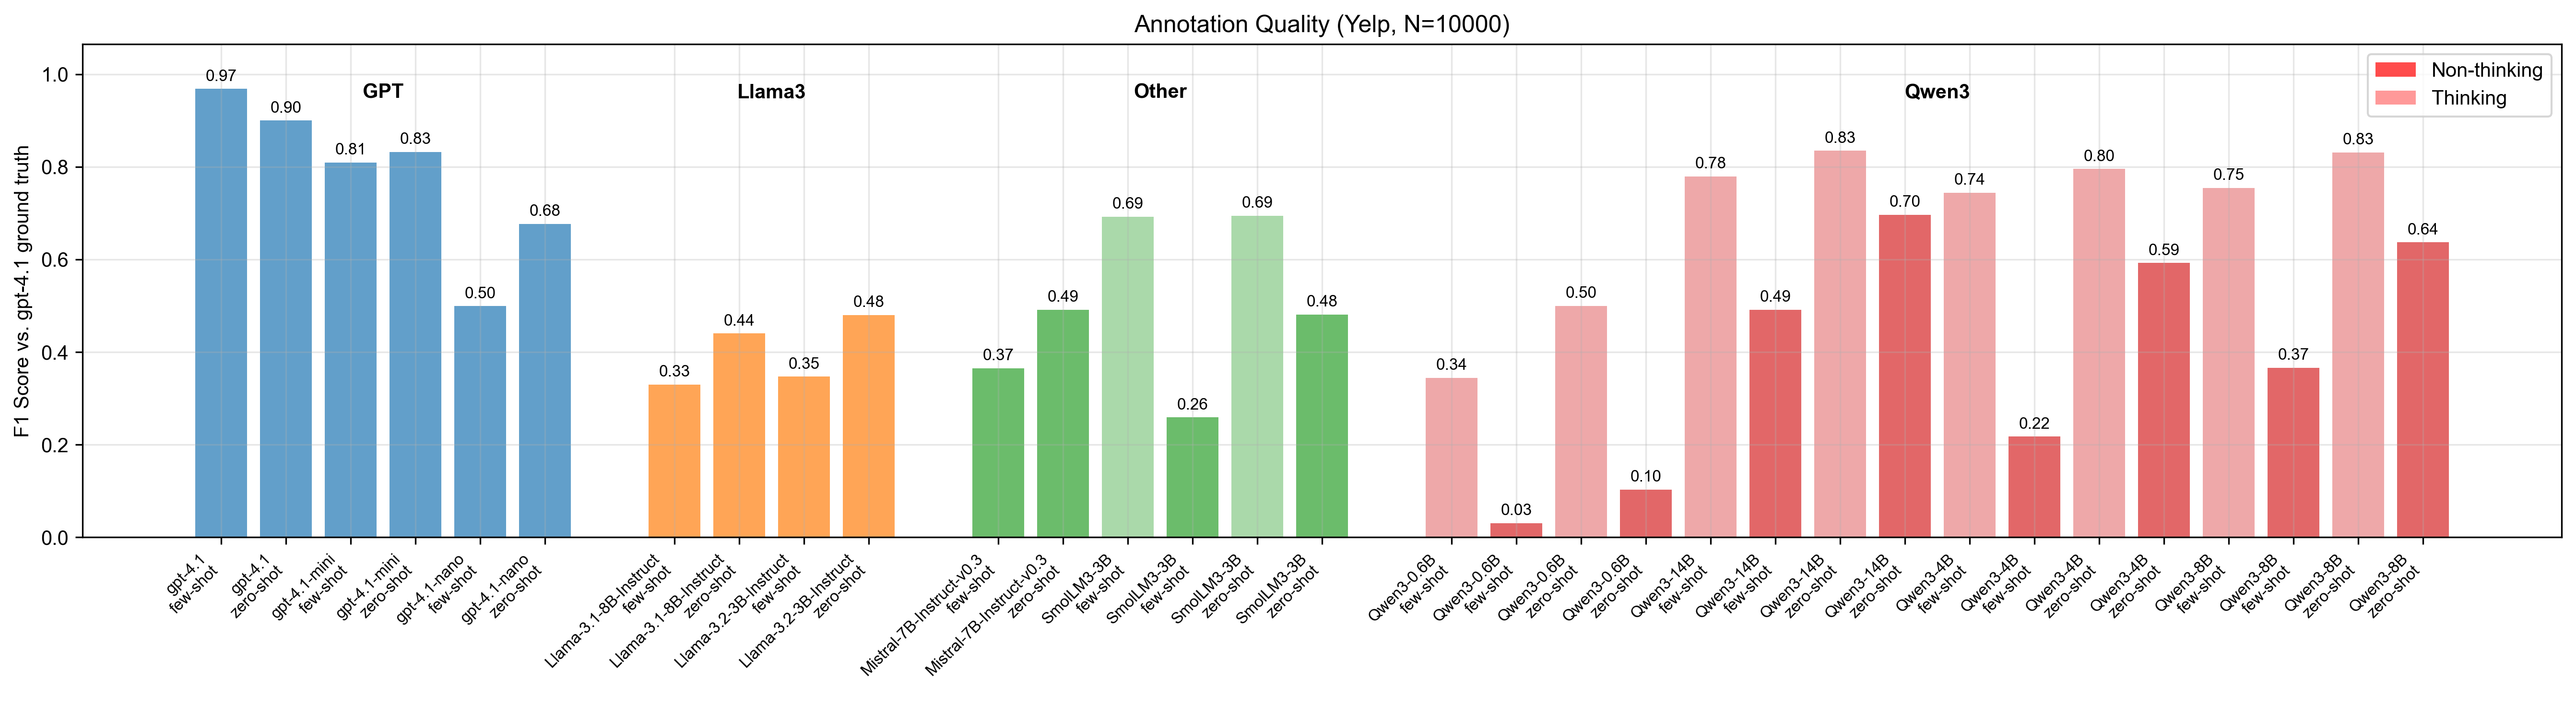

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def model_to_group(row):
    if 'gpt' in row['model_name'].lower():
        return 'GPT'
    # elif row['thinking']:
    #     return 'Reasoning'
    elif 'qwen' in row['model_name'].lower():
        return 'Qwen3'
    elif 'llama' in row['model_name'].lower():
        return 'Llama3'
    elif 'gemma' in row['model_name'].lower():
        return 'Gemma'
    else:
        return 'Other'
    
def model_to_label(row, include_thinking=False):
    label_result = ''
    model_name = row['model_name']
    if '/' in model_name:
        model_name = model_name.split('/')[-1]
    label_result += f'{model_name}'
    prompt = row['prompt']
    if prompt == 'annotate-simple':
        label_result += f'\nzero-shot'
    elif prompt == 'annotate':
        label_result += f'\nfew-shot'
    if include_thinking:
        label_result += f'\nthinking={row["thinking"]}'
    return label_result

# Filter results for temperature=0.0 and exclude simple prompts
filtered_df = results_df[
    (results_df['temperature'] == 0.0) 
    & (~results_df['model_name'].str.contains('gemma'))
    # & (~results_df['prompt'].str.contains('simple', case=False, na=False))
].copy()

# Add display labels
# include_thinking = filtered_df['thinking'].nunique() > 1
include_thinking = False
filtered_df['model_group'] = filtered_df.apply(model_to_group, axis=1)
filtered_df['prompt_label'] = filtered_df.apply(lambda row: model_to_label(row, include_thinking), axis=1)

# Group by model
model_groups = filtered_df.groupby('model_group')

# Create the plot
fig, ax = plt.subplots(figsize=(2 + len(filtered_df) * 0.5, 5), dpi=300)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

x_pos = 0
bar_width = 0.8
group_positions = []
all_f1_values = []
all_labels = []
group_centers = []
for i, (model_label, group_data) in enumerate(model_groups):
    color = colors[i % len(colors)]
    
    # Sort group data alphabetically by prompt_label
    group_data_sorted = group_data.sort_values('prompt_label')
    
    group_f1_scores = group_data_sorted['f1'].values
    group_positions.extend(range(x_pos, x_pos + len(group_data_sorted)))
    all_f1_values.extend(group_f1_scores)
    
    # Use prompt labels for x-axis
    prompt_labels = group_data_sorted['prompt_label'].values
    all_labels.extend(prompt_labels)
    
    # Calculate group center for group label
    group_center = x_pos + (len(group_data_sorted) - 1) / 2
    group_centers.append((group_center, model_label))
    
    # Plot vertical bars for this group with different opacity based on thinking
    for j, (idx, row) in enumerate(group_data_sorted.iterrows()):
        alpha = 0.4 if row['thinking'] else 0.7
        bar = ax.bar(x_pos + j, row['f1'], bar_width, color=color, alpha=alpha)
        
        # Add value labels on bars
        ax.text(bar[0].get_x() + bar[0].get_width()/2, bar[0].get_height() + 0.01,
                f'{row["f1"]:.2f}', ha='center', va='bottom', fontsize=8)
    
    x_pos += len(group_data_sorted) + 1  # Add space between groups

# Customize the plot
ax.set_ylabel('F1 Score vs. gpt-4.1 ground truth')
ax.set_title(f'Annotation Quality (Yelp, N={len(y_true)})')
ax.set_xticks(group_positions)
ax.set_xticklabels(all_labels, fontsize=8, rotation=45, ha='right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(all_f1_values) * 1.1)

# Add legend for thinking vs non-thinking
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='Non-thinking'),
    Patch(facecolor='red', alpha=0.4, label='Thinking')
]
ax.legend(handles=legend_elements, loc='upper right')


# Add group labels below the x-axis
for center, group_label in group_centers:
    ax.text(center, 0.95 * max(all_f1_values), group_label, 
            ha='center', va='top', fontsize=10, fontweight='bold',
            transform=ax.get_xaxis_transform())

plt.tight_layout()
plt.show()


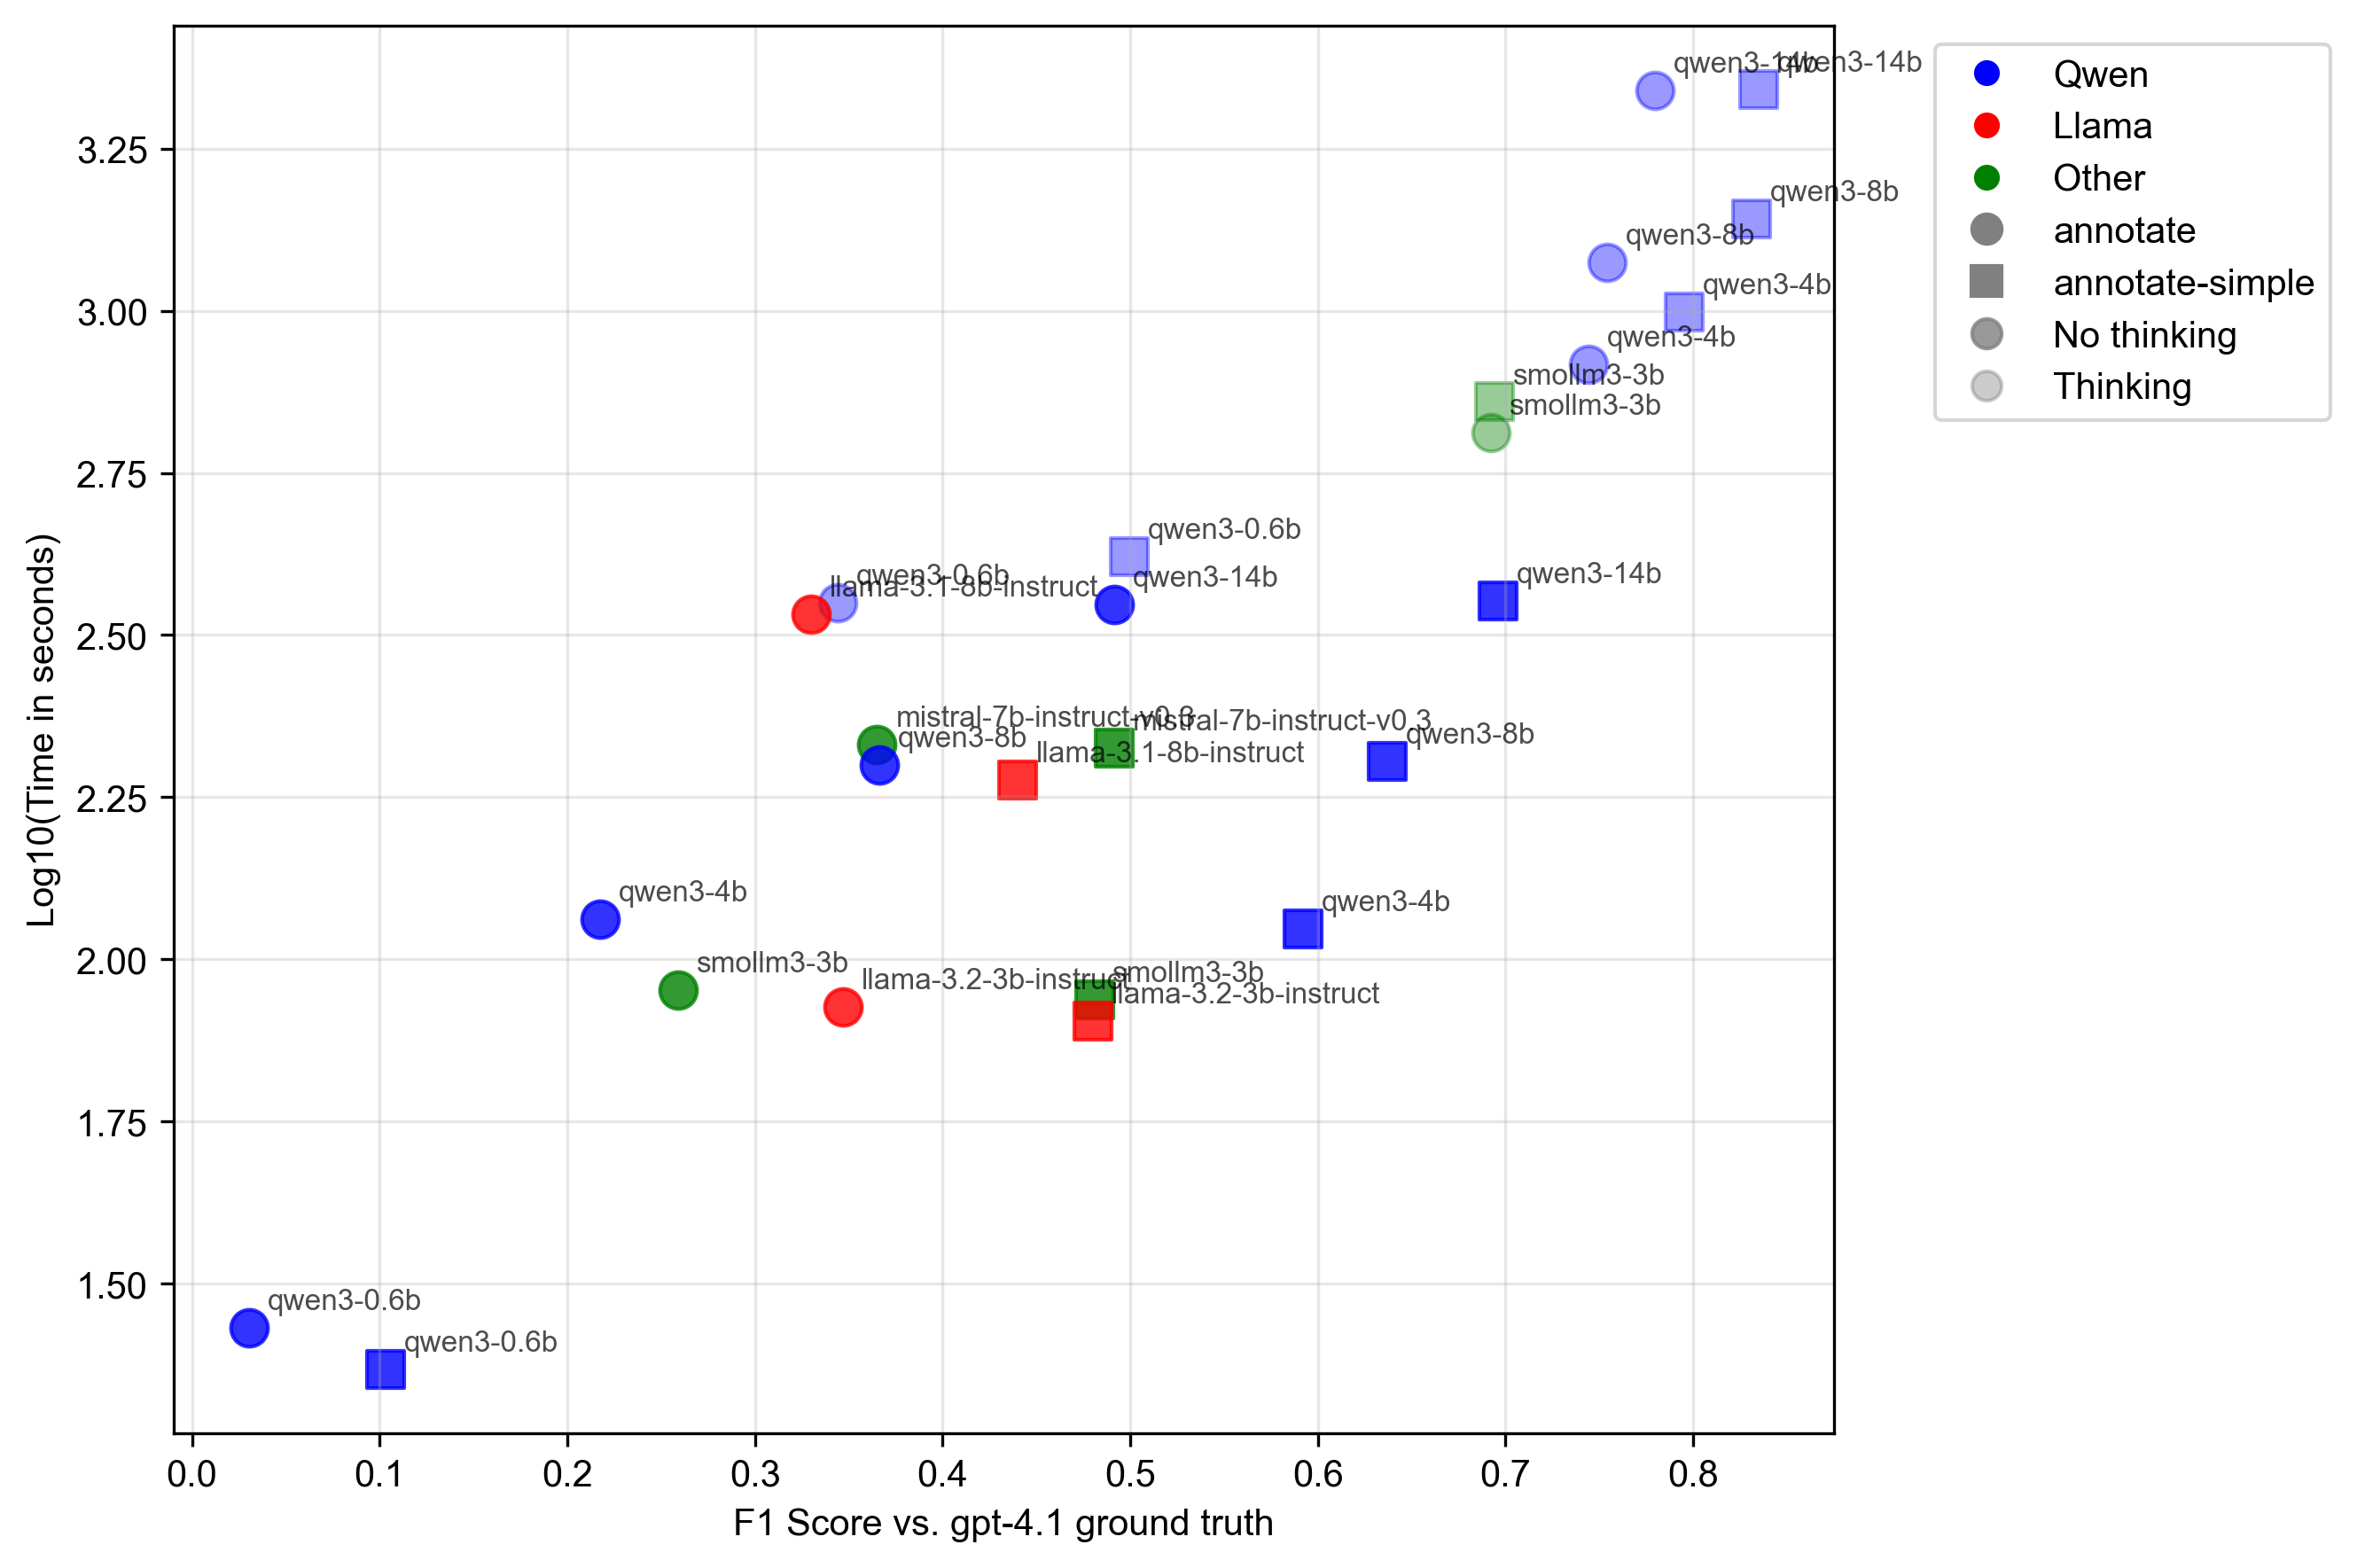

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load timing and results data
df_timing = pd.read_json(os.path.join(CACHE_DIR, "timing_results.jsonl"), lines=True)

# Merge with results data to get F1 scores
df_merged = df_timing.merge(filtered_df, on=['model_name', 'prompt', 'thinking'], how='inner')

# Extract model family and clean model names
def get_model_family(model_name):
    if 'Qwen' in model_name:
        return 'Qwen'
    elif 'Llama' in model_name or 'llama' in model_name:
        return 'Llama'
    else:
        return 'Other'

def clean_model_name(model_name):
    # Extract just the model name without organization prefix
    if '/' in model_name:
        return model_name.split('/')[-1].lower()
    return model_name.lower()

df_merged['model_family'] = df_merged['model_name'].apply(get_model_family)
df_merged['clean_model_name'] = df_merged['model_name'].apply(clean_model_name)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

family_colors = {'Qwen': 'blue', 'Llama': 'red', 'Other': 'green'}
prompt_markers = {'annotate': 'o', 'annotate-simple': 's'}
thinking_alpha = {'True': 0.4, 'False': 0.8}

for _, row in df_merged.iterrows():
    color = family_colors[row['model_family']]
    marker = prompt_markers[row['prompt']]
    alpha = thinking_alpha[str(row['thinking'])]
    
    ax.scatter(row['f1'], np.log10(row['time (s)']), 
              color=color, marker=marker, alpha=alpha, s=100)
    
    # Label points with model names
    ax.annotate(row['clean_model_name'], 
               (row['f1'], np.log10(row['time (s)'])),
               xytext=(5, 5), textcoords='offset points',
               fontsize=8, alpha=0.7)

# Customize the plot
ax.set_xlabel('F1 Score vs. gpt-4.1 ground truth')
ax.set_ylabel('Log10(Time in seconds)')
ax.grid(True, alpha=0.3)

# Create legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = []

# Model family colors
for family, color in family_colors.items():
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=8, label=family))

# Prompt markers
for prompt, marker in prompt_markers.items():
    legend_elements.append(Line2D([0], [0], marker=marker, color='gray', 
                                 markersize=8, label=prompt, linestyle='None'))

# Thinking alpha
legend_elements.append(Line2D([0], [0], marker='o', color='gray', alpha=0.8,
                             markersize=8, label='No thinking', linestyle='None'))
legend_elements.append(Line2D([0], [0], marker='o', color='gray', alpha=0.4,
                             markersize=8, label='Thinking', linestyle='None'))

ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()
